# Project week 7

For the project this week, you are given a video of a ball rolling over a surface. Your job is now to detect the ball, track the position, velocity and acceleration using a Kalman filter, and finally draw the currently tracked position and predicted position of the ball in the images, while also printing the whole predicted state in either the image or the terminal.

The video "rolling_ball_result.mp4" shows what the end result could look like.

You have to make the Kalman filter yourselves, i.e. initialize the matrices and make a update and predict function. You are of course allowed to use numpy.

You can use the code below and fill in the missing parts.



In [53]:
import cv2
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from imutils.video import VideoStream
import argparse
import imutils
import time

In [40]:
def update(x, P, Z, H, R):
    ### Insert update function
    y = Z - H@x
    s = H@P@H.T + R
    K = P@H.T@np.linalg.pinv(s)
    new_x = x + K@y
    new_P = (np.identity((K@H).shape[0]) - K@H)@P
    return new_x, new_P
    
def predict(x, P, F, u, Q):
    ### insert predict function
    new_x = F@x + u
    new_P = F@P@F.T + Q # Q=0. No internal disturbtion
    return new_x, new_P
    
    

#### Attempt 1: red balls

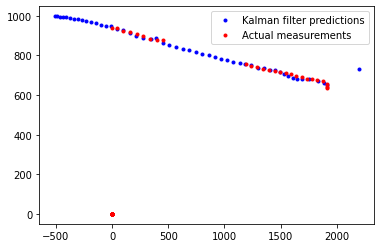

In [66]:
### Initialize Kalman filter ###
# The initial state (6x1).
x = np.array([[0],  # Position along the x-axis
              [0],  # Position along the y-axis
              [0],  # Velocity along the x-axis
              [0],  # Velocity along the y-axis 
              [0],  # Acceleration along the x
              [0]]) # Acceleration along the y

# The initial uncertainty (6x6).
P = np.array([[1000, 0, 0, 0, 0, 0],
              [0, 1000, 0, 0, 0, 0],
              [0, 0, 1000, 0, 0, 0],
              [0, 0, 0, 1000, 0, 0],
              [0, 0, 0, 0, 1000, 0],
              [0, 0, 0, 0, 0, 1000]])

# The external motion (6x1).
u = np.array([[0],
              [0],
              [0],
              [0],
              [0],
              [0]])

# The transition matrix (6x6). 
# The transition matrix. 
F = np.array([[1, 0, 1, 0, 0.5, 0],
              [0, 1, 0, 1, 0, 0.5],
              [0, 0, 1, 0, 1, 0],
              [0, 0, 0, 1, 0, 1],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

# The observation matrix (2x6).
H = np.array([  [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 25*np.array([[1, 0],
                [0, 1]])
# Disturbance matrix
# How little do you want to trust the model?
Q = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

# VARIABLE INIT
blue_lower = (90,70,70)
blue_upper = (100,255,255)
red_lower = (0, 180, 150)
red_upper = (9, 255, 255)
yellow_lower = (20, 100, 100)
yellow_upper = (40, 255, 255)
pts = deque(maxlen=20)
cap = cv2.VideoCapture("rolling_ball.mp4")
cap.set(3, 1280)  # width
cap.set(4, 720)  # height


zs = []
xs = []

while True:
    ret, frame = cap.read()
    if frame is None:
        break
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, red_lower, red_upper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None

    #  DRAW THE CENTER + RED LINE
    if len(cnts) > 0:
        # find the largest contour in the mask
        # use it to compute the minimum enclosing circle and centroid
        c = max(cnts, key=cv2.contourArea)
        ((a, b), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        """
        Kalman magic
        """
        z = np.array([[a],
                      [b]])           
        zs.append(z)
        x, P = update(x, P, z, H, R)

        
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        if radius > 10:
            cv2.circle(frame, (int(a), int(b)), int(radius), (0, 255, 255), 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
    else:
        z = np.array([[0],
                        [0]])
        zs.append(z)

    """ Kalman magic"""
    x, P = predict(x, P, F, u, Q)
    xs.append(x)

    pts.appendleft(center)

    # DRAW THE CIRCLES
    for i in range(1, len(pts)):
        if pts[i - 1] is None or pts[i] is None:
            continue
        cv2.line(frame, pts[i - 1], pts[i], (0, 0, 255), 2)

    # SHOW THE IMAGES
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # PROGRAM TERMINATION
    if key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


xs = np.asarray(xs)
zs = np.asarray(zs)

plt.plot(xs[:, 0, 0], xs[:, 1, 0], ".b")
plt.plot(zs[:, 0, 0], zs[:, 1, 0], ".r")
plt.legend(["Kalman filter predictions",
            "Actual measurements"])
plt.show()


#### Attempt 2: Yellow ball in challenge video

Try showing the video "rolling_ball_result.mp4" instead, to see what the end result could look like.

## Hints

The first part is to detect the ball. For this part you can look back to the exercises from week 2. More specifically the end of exercise 1. You may have to adjust some parameters in order to only detect the ball.

The next part is to make the Kalman filter. If you did the exercises from monday this week, you already have a suitable update and predict function. You will have to initialize all the different matrices, which we also did in the exercises, however this time we would like the state to include position, velocity and acceleration in both the x- and y-direction (6 states).

Start by defining your state **x** and uncertainty **P**. Then define a transition matrix **F** based on your state. When defining the state transition last time we used the equation for linear motion:

![Eq](equation.png)

We used dt = 1 (delta t), for simplicity. You can do the same here. However, this time we also have the acceleration and therefore we use:

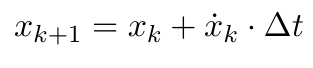
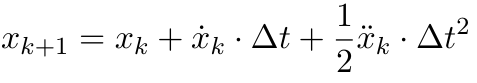

Finally, for a part of the video, the ball is behind something and can't be seen. Obviously we cant update our state here, because there is no measurement. So when there is no measurements available, you should only use the predict function and not the update function, to estimate the state.


# Challenge

If you can't get enough of tracking and Kalman filters, try extending your program, such that it can keep track of multiple balls at the same time. Use the video "rolling_ball_challenge.mp4" to test it. You can take advantage of the balls having different colours.

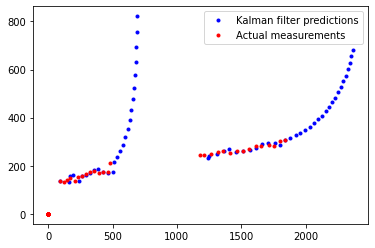

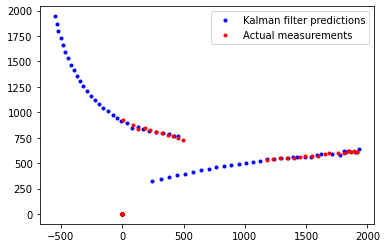

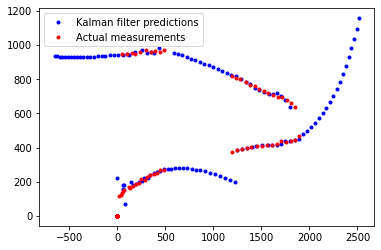

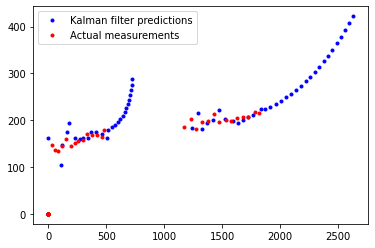

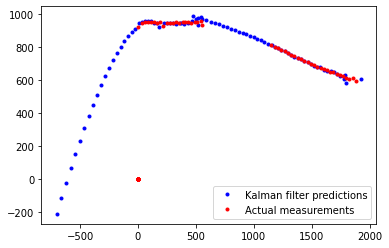

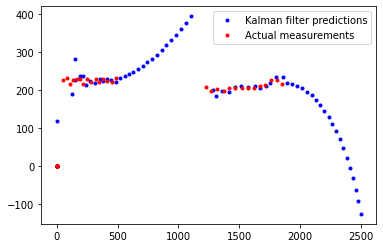

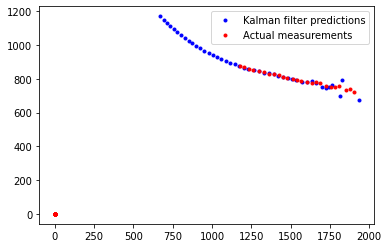

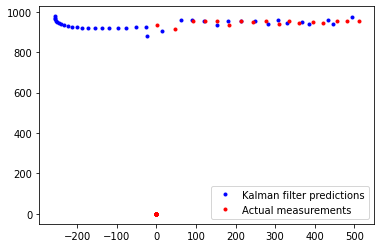

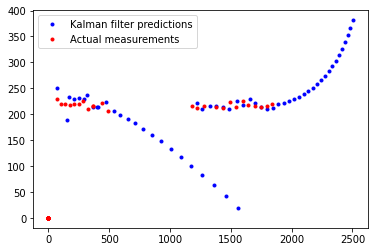

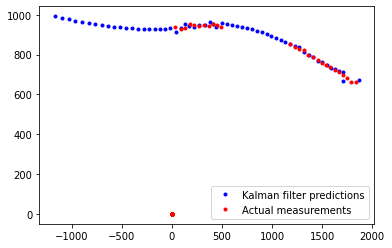

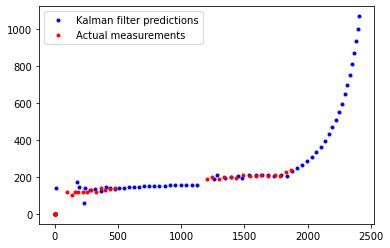

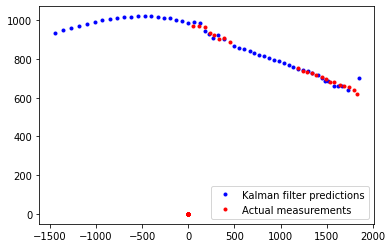

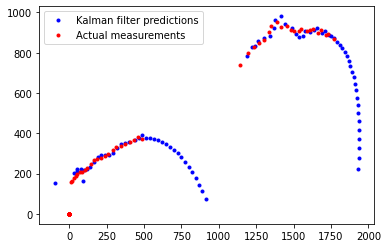

In [68]:
### Initialize Kalman filter ###
# The initial state (6x1).
x = np.array([[0],  # Position along the x-axis
              [0],  # Position along the y-axis
              [0],  # Velocity along the x-axis
              [0],  # Velocity along the y-axis 
              [0],  # Acceleration along the x
              [0]]) # Acceleration along the y

# The initial uncertainty (6x6).
P = np.array([[1000, 0, 0, 0, 0, 0],
              [0, 1000, 0, 0, 0, 0],
              [0, 0, 1000, 0, 0, 0],
              [0, 0, 0, 1000, 0, 0],
              [0, 0, 0, 0, 1000, 0],
              [0, 0, 0, 0, 0, 1000]])

# The external motion (6x1).
u = np.array([[0],
              [0],
              [0],
              [0],
              [0],
              [0]])

# The transition matrix (6x6). 
# The transition matrix. 
F = np.array([[1, 0, 1, 0, 0.5, 0],
              [0, 1, 0, 1, 0, 0.5],
              [0, 0, 1, 0, 1, 0],
              [0, 0, 0, 1, 0, 1],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

# The observation matrix (2x6).
H = np.array([  [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = 15*np.array([[1, 0], # 25 is good
                [0, 1]])
# Disturbance matrix
# How little do you want to trust the model?
Q = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

# Load the video
cap = cv2.VideoCapture('rolling_ball_challenge.mp4')
if not cap.isOpened():
    print("Cannot open video")
    exit()

# Detect the yellow ball
lower = (20, 100, 100)  # hsv
upper = (40, 255, 255)  # hsv
pts = deque(maxlen=20)

# Looping through all the frames
xs = []
zs = []
no_measure_window = 0
no_measure_limit = 20 # How long before resetting the filter

while True:
    ret, frame = cap.read()
    if not ret:
        break

    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # FIND THE DESIRED COLOR
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.GaussianBlur(mask, (21, 21), 0)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # FIND THE CIRCLES
    minDist = 1400  # distance between circles
    param1 = 40  # default value 40, don't ask why, I dunno
    param2 = 25  # smaller value-> more false circles
    minRadius = 10
    maxRadius = 160
    detected_circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1, minDist,
                                        param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

   # DRAW THE CONTOUR
    if detected_circles is not None:
        no_measure_window = 0
        # convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(detected_circles))
        pt = detected_circles[0, :][0]
        a, b, r = pt[0], pt[1], pt[2]  # parameters of the circle
        cv2.circle(frame, (a, b), r, (0, 0, 255), 5)  # draw the dircle
        cv2.circle(frame, (a, b), 1, (0, 0, 255), 5)  # draw the center
        
        z = np.array([[a],
                      [b]]) 
        zs.append(z)

        ### If the ball is found, update the Kalman filter ###
        x, P = update(x, P, z, H, R)
        
    else:
        no_measure_window += 1
        if no_measure_window<no_measure_limit:
            # Stop measuring if we havent seen ball in a while
            z = np.array([[0],
                        [0]]) 
            zs.append(z)
        
    
    ### Predict the next state
    if no_measure_window<no_measure_limit:
        x, P = predict(x, P, F, u, Q)
        xs.append(x)
    else: # Reset uncertainty if we haven't seen ball in a while
        P = np.array([[1000, 0, 0, 0, 0, 0],
                      [0, 1000, 0, 0, 0, 0],
                      [0, 0, 1000, 0, 0, 0],
                      [0, 0, 0, 1000, 0, 0],
                      [0, 0, 0, 0, 1000, 0],
                      [0, 0, 0, 0, 0, 1000]])
        # Plot the path and measurements, and reset trajectory vectors.
        if len(xs)>0:
            xs = np.asarray(xs)
            zs = np.asarray(zs)
            #xs.shape
            plt.plot(xs[:, 0, 0], xs[:, 1, 0], ".b")
            plt.plot(zs[:, 0, 0], zs[:, 1, 0], ".r")
            plt.legend(["Kalman filter predictions",
                        "Actual measurements"])
            plt.show()
            xs = []
            zs = []

    # SHOW THE IMAGE
    cv2.imshow('frame', frame)

    # PROGRAM TERMINATION
    if cv2.waitKey(1) & 0xFF == ord('q'):  # q will end the program
        cap.release()
        cv2.destroyAllWindows()  # free memory
        quit()
        
    ### Draw the current tracked state and the predicted state on the image frame ###
    # Show the frame
    #cv2.waitKey(200)
    
cap.release()
cv2.destroyAllWindows()